# Climate Trace: Copper Mining Data Exploration & Cleaning

**Objective:** Prepare the dataset to answer **Question 1: Stranded Assets & Transition Risk**.  
**Target:** A clean, merged asset-level dataset with ownership and uncertainty flags.  
**Output:** `copper_mining_cleaned.csv` (914 mines, 29 columns, year 2024)

---

## Table of Contents

1. [Load Datasets](#1.-Load-Datasets)
2. [Initial Inspection](#2.-Initial-Inspection-(Dimensions-&-Keys))
3. [Main Dataset Exploration](#3.-Main-Dataset-Exploration-(The-"Core"))
4. [Ownership Exploration](#4.-Ownership-Exploration)
5. [Confidence Exploration](#5.-Confidence-Exploration)
6. [Data Cleaning Pipeline](#6.-Data-Cleaning-Pipeline) (Steps 1-10)
7. [Visualizations & Insights](#7.-Visualizations-&-Insights)
8. [Known Limitations](#8.-Known-Limitations)
9. [Output Data Dictionary](#9.-Output-Data-Dictionary)

---

## Data Sources

| File | Description | Rows |
|------|-------------|------|
| `copper-mining_emissions_sources_v5_2_0.csv` | Monthly emissions per mine (co2e_100yr) | 53,012 |
| `copper-mining_emissions_sources_ownership_v5_2_0.csv` | Mine-to-parent company mapping | 1,419 |
| `copper-mining_emissions_sources_confidence_v5_2_0.csv` | Data quality flags per record | 53,012 |
| `copper-mining_country_emissions_v5_2_0.csv` | Country-level annual totals (validation) | 2,772 |

In [56]:
!uv pip install pandas numpy matplotlib seaborn

Audited 4 packages in 26ms


In [ ]:
import zipfile
import os

# Extract datasets if not already done
ZIP_FILE = "copper_datasets.zip"
EXTRACT_DIR = "extracted_data"

if not os.path.exists(f"{EXTRACT_DIR}/DATA"):
    print(f"Extracting {ZIP_FILE}...")
    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    print(f"Extracted to {EXTRACT_DIR}/")
else:
    print(f"Data already extracted in {EXTRACT_DIR}/")

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

## 1. Load Datasets

In [58]:
# Define file paths
main_file = "copper_mining.csv"
ownership_file = "extracted_data/DATA/copper-mining_emissions_sources_ownership_v5_2_0.csv"
confidence_file = "extracted_data/DATA/copper-mining_emissions_sources_confidence_v5_2_0.csv"
country_file = "extracted_data/DATA/copper-mining_country_emissions_v5_2_0.csv"

# Load data
df_main = pd.read_csv(main_file)
df_owner = pd.read_csv(ownership_file)
df_conf = pd.read_csv(confidence_file)
df_country = pd.read_csv(country_file)

print("Datasets loaded successfully.")

Datasets loaded successfully.


## 2. Initial Inspection (Dimensions & Keys)

In [59]:
def inspect_df(name, df):
    print(f"--- {name} ---")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Unique Sources: {df['source_id'].nunique() if 'source_id' in df.columns else 'N/A'}")
    print("\n")

inspect_df("Main Dataset", df_main)
inspect_df("Ownership", df_owner)
inspect_df("Confidence", df_conf)
inspect_df("Country Totals", df_country)

--- Main Dataset ---
Shape: (51184, 47)
Columns: ['source_id', 'source_name', 'source_type', 'iso3_country', 'sector', 'subsector', 'start_time', 'end_time', 'lat', 'lon', 'geometry_ref', 'gas', 'emissions_quantity', 'temporal_granularity', 'activity', 'activity_units', 'emissions_factor', 'emissions_factor_units', 'capacity', 'capacity_units', 'capacity_factor', 'other1', 'other1_def', 'other2', 'other2_def', 'other3', 'other3_def', 'other4', 'other4_def', 'other5', 'other5_def', 'other6', 'other6_def', 'other7', 'other7_def', 'other8', 'other8_def', 'other9', 'other9_def', 'other10', 'other10_def', 'created_date', 'modified_date', 'sector_id', 'lat_lon', 'reporting_entity', 'native_source_id']
Unique Sources: 914


--- Ownership ---
Shape: (1419, 18)
Columns: ['parent_name', 'parent_entity_id', 'parent_entity_type', 'parent_lei', 'parent_permid', 'parent_registration_country', 'parent_headquarter_country', 'overall_share_percent', 'ownership_path', 'ownership_path_datasource_ids', 'i

## 3. Main Dataset Exploration (The "Core")
We need to check:
1.  **Temporal Coverage**: Do we have 2023/2024 data?
2.  **Missing Values**: Specifically `activity` and `emissions_quantity`.
3.  **Status**: How many mines are "Closed"?

In [60]:
# Check Date Range
df_main['start_time'] = pd.to_datetime(df_main['start_time'])
print(f"Time Range: {df_main['start_time'].min()} to {df_main['start_time'].max()}")

# Check Nulls
cols_of_interest = ['source_name', 'iso3_country', 'emissions_quantity', 'activity', 'capacity', 'other2']
print("Target Column Nulls:\n", df_main[cols_of_interest].isnull().sum())

# Check Status Distribution
print("\nMine Status Distribution:")
print(df_main['other2'].value_counts())

Time Range: 2021-01-01 00:00:00 to 2025-08-01 00:00:00
Target Column Nulls:
 source_name           0
iso3_country          0
emissions_quantity    0
activity              0
capacity              0
other2                0
dtype: int64

Mine Status Distribution:
other2
Production    34120
Closed        10644
Suspended      6300
Proposed        120
Name: count, dtype: int64


## 4. Ownership Exploration
Check if we can easily map mines to companies. Are there duplicates (one mine, multiple owners)?

In [61]:
# Check for duplicate source_id in ownership file
dupe_owners = df_owner['source_id'].duplicated().sum()
print(f"Number of mines with multiple ownership records: {dupe_owners}")

# Preview duplicates if any
if dupe_owners > 0:
    print(df_owner[df_owner['source_id'].duplicated(keep=False)].sort_values('source_id')[['source_name', 'parent_name', 'overall_share_percent']].head(10))

Number of mines with multiple ownership records: 888
      source_name                             parent_name  \
683  Lindero Mine                                     NaN   
684  Lindero Mine                                     NaN   
685  Lindero Mine                Fortuna Silver Mines Inc   
563  Kajaran Mine  Zangezur Copper-Molybdenum Combine JSC   
561  Kajaran Mine                                     NaN   
562  Kajaran Mine                                     NaN   
30    Ankata Mine                           BlackRock Inc   
29    Ankata Mine                    small shareholder(s)   
28    Ankata Mine                       State Street Corp   
27    Ankata Mine                             Dodge & Cox   

     overall_share_percent  
683                    NaN  
684                    NaN  
685                    NaN  
563                    NaN  
561                    NaN  
562                    NaN  
30                     NaN  
29                     NaN  
28            

## 5. Confidence Exploration
How confident are the estimates?

In [62]:
print("Confidence Levels for Emissions:")
print(df_conf['emissions_quantity'].value_counts())

Confidence Levels for Emissions:
emissions_quantity
very low    45140
medium       5688
low          1248
high          936
Name: count, dtype: int64


---
## 6. Data Cleaning Pipeline

Now we implement the cleaning steps to create `copper_mining_cleaned.csv`.

In [63]:
# Configuration
MAIN_FILE = "extracted_data/DATA/copper-mining_emissions_sources_v5_2_0.csv"
OWNERSHIP_FILE = "extracted_data/DATA/copper-mining_emissions_sources_ownership_v5_2_0.csv"
CONFIDENCE_FILE = "extracted_data/DATA/copper-mining_emissions_sources_confidence_v5_2_0.csv"
COUNTRY_FILE = "extracted_data/DATA/copper-mining_country_emissions_v5_2_0.csv"
OUTPUT_FILE = "copper_mining_cleaned.csv"
CARBON_PRICES = [50, 100, 150, 200]  # USD per tonne CO2e

# Load data
df_main = pd.read_csv(MAIN_FILE)
df_owner = pd.read_csv(OWNERSHIP_FILE)
df_conf = pd.read_csv(CONFIDENCE_FILE)
df_country = pd.read_csv(COUNTRY_FILE)

df_main['start_time'] = pd.to_datetime(df_main['start_time'])
df_main['end_time'] = pd.to_datetime(df_main['end_time'])
df_main['year'] = df_main['start_time'].dt.year
df_main['month'] = df_main['start_time'].dt.month

print(f"Loaded {MAIN_FILE}")
print(f"Shape: {df_main.shape}")
print(f"Gas type: {df_main['gas'].unique()}")
print(f"Time range: {df_main['year'].min()} - {df_main['year'].max()}")

Loaded extracted_data/DATA/copper-mining_emissions_sources_v5_2_0.csv
Shape: (53012, 49)
Gas type: ['co2e_100yr']
Time range: 2021 - 2025


In [64]:
# Analyze temporal coverage
year_summary = df_main.groupby('year').agg({
    'source_id': 'nunique',
    'month': 'nunique',
    'emissions_quantity': 'sum'
}).rename(columns={
    'source_id': 'unique_mines',
    'month': 'months_covered',
    'emissions_quantity': 'total_emissions'
})
print("=== Temporal Coverage by Year ===")
print(year_summary)

# Select latest year with sufficient data
for candidate_year in [2024, 2023, 2022]:
    months_in_year = df_main[df_main['year'] == candidate_year]['month'].nunique()
    if months_in_year >= 7:
        TARGET_YEAR = candidate_year
        print(f"\nSelected TARGET_YEAR = {TARGET_YEAR} ({months_in_year} months of data)")
        break

df_filtered = df_main[df_main['year'] == TARGET_YEAR].copy()
print(f"Filtered dataset: {len(df_filtered)} monthly records")
print(f"Unique mines: {df_filtered['source_id'].nunique()}")

=== Temporal Coverage by Year ===
      unique_mines  months_covered  total_emissions
year                                               
2021           914              12     9.242515e+07
2022           914              12     9.516820e+07
2023           914              12     1.036039e+08
2024           914              12     9.520471e+07
2025           914              10     7.880630e+07

Selected TARGET_YEAR = 2024 (12 months of data)
Filtered dataset: 10968 monthly records
Unique mines: 914


In [65]:
print("=== Mine Status Distribution ===")
print(df_filtered['other2'].value_counts(dropna=False))

df_filtered['mine_status'] = df_filtered['other2']
ACTIVE_STATUSES = ['Production']
df_filtered['include_in_intensity'] = df_filtered['mine_status'].isin(ACTIVE_STATUSES)
df_filtered['data_quality_flag'] = None
df_filtered['activity_issue'] = False

# Flag Production mines with zero/null activity
production_zero_activity = (
    (df_filtered['mine_status'] == 'Production') & 
    ((df_filtered['activity'] == 0) | (df_filtered['activity'].isna()))
)
df_filtered.loc[production_zero_activity, 'activity_issue'] = True
df_filtered.loc[production_zero_activity, 'data_quality_flag'] = 'production_no_activity'

print(f"\n=== Data Quality Summary ===")
print(f"Active mines (Production status): {df_filtered['include_in_intensity'].sum()}")
print(f"Production mines with activity issues: {production_zero_activity.sum()}")
print(f"Closed/inactive records: {(~df_filtered['include_in_intensity']).sum()}")

=== Mine Status Distribution ===
other2
Production    7296
Closed        2304
Suspended     1368
Name: count, dtype: int64

=== Data Quality Summary ===
Active mines (Production status): 7296
Production mines with activity issues: 84
Closed/inactive records: 3672


In [66]:
agg_rules = {
    'source_name': 'first',
    'iso3_country': 'first',
    'lat': 'first',
    'lon': 'first',
    'emissions_quantity': 'sum',
    'activity': 'sum',
    'capacity': 'mean',
    'capacity_factor': 'mean',
    'mine_status': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0],
    'other1': 'first',
    'other3': 'first',
    'include_in_intensity': 'any',
    'activity_issue': 'any',
    'data_quality_flag': lambda x: x.dropna().iloc[0] if len(x.dropna()) > 0 else None
}

df_annual = df_filtered.groupby(['source_id', 'year']).agg(agg_rules).reset_index()
df_annual = df_annual.rename(columns={
    'emissions_quantity': 'annual_emissions_t_co2e',
    'activity': 'annual_production_t_ore',
    'capacity': 'avg_capacity_t',
    'other1': 'mine_type',
    'other3': 'other_minerals'
})

print(f"=== Aggregated to Annual Level ===")
print(f"Total mine-year records: {len(df_annual)}")
print(f"Unique mines: {df_annual['source_id'].nunique()}")
print(f"\nSample data:")
print(df_annual[['source_name', 'iso3_country', 'annual_emissions_t_co2e', 
                  'annual_production_t_ore', 'mine_status']].head(10))

=== Aggregated to Annual Level ===
Total mine-year records: 914
Unique mines: 914

Sample data:
      source_name iso3_country  annual_emissions_t_co2e  \
0      Karma Mine          ALB                 0.000000   
1  Lak Roshi Mine          ALB                 0.000000   
2    Munella Mine          ALB             22224.000002   
3  Qafe Bari Mine          ALB                 0.000000   
4       Spac Mine          ALB                 0.000000   
5  Alumbrera Mine          ARG                 0.000000   
6    Lindero Mine          ARG            132442.000000   
7     Agarak Mine          ARM             52650.000225   
8    Kajaran Mine          ARM            956837.004094   
9      Kapan Mine          ARM              7922.000034   

   annual_production_t_ore mine_status  
0             0.000000e+00      Closed  
1             0.000000e+00  Production  
2             1.481606e+06  Production  
3             0.000000e+00  Production  
4             0.000000e+00   Suspended  
5       

In [67]:
# Carbon Intensity = Emissions / Production
df_annual['carbon_intensity'] = np.where(
    (df_annual['include_in_intensity']) & 
    (df_annual['annual_production_t_ore'] > 0) &
    (~df_annual['activity_issue']),
    df_annual['annual_emissions_t_co2e'] / df_annual['annual_production_t_ore'],
    np.nan
)

print("=== Carbon Intensity Statistics ===")
print(df_annual['carbon_intensity'].describe())

# Flag outliers (>3 std from mean)
intensity_mean = df_annual['carbon_intensity'].mean()
intensity_std = df_annual['carbon_intensity'].std()
intensity_upper = intensity_mean + 3 * intensity_std
df_annual['intensity_outlier'] = df_annual['carbon_intensity'] > intensity_upper

print(f"\nMean intensity: {intensity_mean:.4f} t CO2e/t ore")
print(f"Std deviation: {intensity_std:.4f}")
print(f"Outlier threshold (mean + 3*std): {intensity_upper:.4f}")
print(f"Intensity outliers flagged: {df_annual['intensity_outlier'].sum()}")

print("\n=== Top 10 Most Carbon-Intensive Mines ===")
top_intensity = df_annual.nlargest(10, 'carbon_intensity')[
    ['source_name', 'iso3_country', 'carbon_intensity', 'annual_emissions_t_co2e', 'annual_production_t_ore']
]
print(top_intensity.to_string())

=== Carbon Intensity Statistics ===
count    601.000000
mean       0.018443
std        0.021378
min        0.000100
25%        0.006600
50%        0.015000
75%        0.024300
max        0.300500
Name: carbon_intensity, dtype: float64

Mean intensity: 0.0184 t CO2e/t ore
Std deviation: 0.0214
Outlier threshold (mean + 3*std): 0.0826
Intensity outliers flagged: 5

=== Top 10 Most Carbon-Intensive Mines ===
              source_name iso3_country  carbon_intensity  annual_emissions_t_co2e  annual_production_t_ore
212      El Salvador Mine          CHL          0.300500             2.164330e+05             7.202420e+05
607            Sepon Mine          LAO          0.276400             1.105600e+05             4.000000e+05
805       Las Cruces Mine          ESP          0.140308             5.000000e+03             3.563600e+04
66    Deflector Operation          AUS          0.098900             1.053730e+05             1.065446e+06
524  Tenke Fungurume Mine          COD          0.094400

In [68]:
print("=== Ownership Data Preparation ===")
print(f"Total ownership records: {len(df_owner)}")
print(f"Unique mines in ownership file: {df_owner['source_id'].nunique()}")

# Take primary parent per mine (first record with parent_name)
df_owner_clean = df_owner[df_owner['parent_name'].notna()].copy()
df_owner_primary = df_owner_clean.groupby('source_id').agg({
    'parent_name': 'first',
    'parent_entity_id': 'first',
    'parent_registration_country': 'first',
    'parent_headquarter_country': 'first',
    'overall_share_percent': 'first',
    'source_operator': 'first'
}).reset_index()

owner_counts = df_owner.groupby('source_id').size().reset_index(name='ownership_complexity')
df_owner_primary = df_owner_primary.merge(owner_counts, on='source_id', how='left')
print(f"Primary owners prepared: {len(df_owner_primary)}")

df_annual = df_annual.merge(
    df_owner_primary[['source_id', 'parent_name', 'parent_headquarter_country', 'source_operator', 'ownership_complexity']],
    on='source_id',
    how='left'
)
df_annual['has_ownership'] = df_annual['parent_name'].notna()

print(f"\n=== Ownership Merge Summary ===")
print(f"Mines with ownership data: {df_annual['has_ownership'].sum()}")
print(f"Mines without ownership data: {(~df_annual['has_ownership']).sum()}")

print("\n=== Top 10 Parent Companies by Mine Count ===")
top_parents = df_annual[df_annual['has_ownership']].groupby('parent_name').size().nlargest(10)
print(top_parents)

=== Ownership Data Preparation ===
Total ownership records: 1419
Unique mines in ownership file: 531
Primary owners prepared: 530

=== Ownership Merge Summary ===
Mines with ownership data: 530
Mines without ownership data: 384

=== Top 10 Parent Companies by Mine Count ===
parent_name
The Vanguard Group Inc        20
Qatar Investment Authority    16
FreePort-McMoran Inc          13
Zijin Mining Group Co Ltd     12
Volcan Compañía Minera SAA     9
Grupo México SAB de CV         8
Barrick Gold Corp              7
Boliden Mineral AB             7
Codelco Corp                   7
Government of Brazil           7
dtype: int64


In [69]:
print("=== Confidence Data Preparation ===")

df_conf['start_time'] = pd.to_datetime(df_conf['start_time'])
df_conf['year'] = df_conf['start_time'].dt.year
df_conf_year = df_conf[df_conf['year'] == TARGET_YEAR].copy()
print(f"Confidence records for {TARGET_YEAR}: {len(df_conf_year)}")

confidence_order = {'very low': 1, 'low': 2, 'medium': 3, 'high': 4, 'very high': 5}
df_conf_year['emissions_conf_numeric'] = df_conf_year['emissions_quantity'].map(confidence_order)
df_conf_year['activity_conf_numeric'] = df_conf_year['activity'].map(confidence_order)

conf_annual = df_conf_year.groupby(['source_id', 'year']).agg({
    'emissions_conf_numeric': 'median',
    'activity_conf_numeric': 'median'
}).reset_index()

reverse_conf = {v: k for k, v in confidence_order.items()}
conf_annual['emissions_confidence'] = conf_annual['emissions_conf_numeric'].round().map(reverse_conf)
conf_annual['activity_confidence'] = conf_annual['activity_conf_numeric'].round().map(reverse_conf)
print(f"Confidence aggregated: {len(conf_annual)} mine-year records")

df_annual = df_annual.merge(
    conf_annual[['source_id', 'year', 'emissions_confidence', 'activity_confidence']],
    on=['source_id', 'year'],
    how='left'
)
df_annual['emissions_confidence'] = df_annual['emissions_confidence'].fillna('unknown')
df_annual['activity_confidence'] = df_annual['activity_confidence'].fillna('unknown')

print("\n=== Confidence Distribution ===")
print("Emissions confidence:")
print(df_annual['emissions_confidence'].value_counts())
print("\nActivity confidence:")
print(df_annual['activity_confidence'].value_counts())

=== Confidence Data Preparation ===
Confidence records for 2024: 10968
Confidence aggregated: 914 mine-year records

=== Confidence Distribution ===
Emissions confidence:
emissions_confidence
medium      474
very low    258
low         104
high         78
Name: count, dtype: int64

Activity confidence:
activity_confidence
medium      330
very low    236
high        193
low         155
Name: count, dtype: int64


In [70]:
print("=== Carbon Cost Exposure Calculations ===")
print(f"Carbon price scenarios: {CARBON_PRICES} USD/tonne CO2e")

for price in CARBON_PRICES:
    col_name = f'carbon_cost_usd_{price}'
    df_annual[col_name] = df_annual['annual_emissions_t_co2e'] * price
    total_cost = df_annual[col_name].sum()
    print(f"  ${price}/t: Total exposure = ${total_cost:,.0f}")

print("\n=== Top 10 Mines by Carbon Cost Exposure ($100/t) ===")
top_exposure = df_annual.nlargest(10, 'carbon_cost_usd_100')[
    ['source_name', 'iso3_country', 'parent_name', 'annual_emissions_t_co2e', 'carbon_cost_usd_100']
]
print(top_exposure.to_string())

=== Carbon Cost Exposure Calculations ===
Carbon price scenarios: [50, 100, 150, 200] USD/tonne CO2e
  $50/t: Total exposure = $4,760,235,286
  $100/t: Total exposure = $9,520,470,572
  $150/t: Total exposure = $14,280,705,858
  $200/t: Total exposure = $19,040,941,144

=== Top 10 Mines by Carbon Cost Exposure ($100/t) ===
                     source_name iso3_country                  parent_name  annual_emissions_t_co2e  carbon_cost_usd_100
557          Sarcheshmeh Complex          IRN           Government of Iran             2.601350e+06         2.601350e+08
668              Antapaccay Mine          PER   Qatar Investment Authority             1.863345e+06         1.863345e+08
378  Dikuluwe-Mashamba West Mine          COD  SinoCongolaise des Mines SA             1.791061e+06         1.791061e+08
549     Grasberg Block Cave Mine          IDN         FreePort-McMoran Inc             1.592699e+06         1.592699e+08
650              Letpadaung Mine          MMR             Wanbao Minin

In [71]:
print("=== Validation: Asset Sum vs Country Totals ===")

df_country['start_time'] = pd.to_datetime(df_country['start_time'])
df_country['year'] = df_country['start_time'].dt.year

country_year = df_country[df_country['year'] == TARGET_YEAR]
country_official = country_year.groupby('iso3_country')['emissions_quantity'].sum()
country_calculated = df_annual.groupby('iso3_country')['annual_emissions_t_co2e'].sum()

validation = pd.DataFrame({
    'official': country_official,
    'calculated': country_calculated
}).fillna(0)
validation['difference'] = validation['official'] - validation['calculated']
validation['pct_diff'] = np.where(
    validation['official'] > 0,
    (validation['difference'] / validation['official'] * 100).round(2),
    0
)

within_1pct = (validation['pct_diff'].abs() < 1).sum()
within_5pct = (validation['pct_diff'].abs() < 5).sum()
total_countries = len(validation[validation['official'] > 0])

print(f"Countries matching within 1%: {within_1pct}/{total_countries}")
print(f"Countries matching within 5%: {within_5pct}/{total_countries}")

total_official = country_year['emissions_quantity'].sum()
total_calculated = df_annual['annual_emissions_t_co2e'].sum()
global_diff_pct = abs(total_official - total_calculated) / total_official * 100 if total_official > 0 else 0

print(f"\n=== Global Totals ===")
print(f"Official aggregate: {total_official:,.0f} tonnes CO2e")
print(f"Calculated from assets: {total_calculated:,.0f} tonnes CO2e")
print(f"Difference: {global_diff_pct:.2f}%")

if global_diff_pct > 5:
    print("WARNING: Global difference exceeds 5%. Review data quality.")
else:
    print("PASSED: Global totals within acceptable tolerance.")

print("\n=== Top 5 Discrepancies by Country ===")
discrepancies = validation[validation['official'] > 0].nlargest(5, 'pct_diff')
print(discrepancies[['official', 'calculated', 'pct_diff']])

=== Validation: Asset Sum vs Country Totals ===
Countries matching within 1%: 234/57
Countries matching within 5%: 234/57

=== Global Totals ===
Official aggregate: 98,483,792 tonnes CO2e
Calculated from assets: 95,204,706 tonnes CO2e
Difference: 3.33%
PASSED: Global totals within acceptable tolerance.

=== Top 5 Discrepancies by Country ===
                  official  calculated  pct_diff
iso3_country                                    
COG           4.648900e+04         0.0    100.00
GEO           9.190000e+03         0.0    100.00
MAR           1.612200e+05         0.0    100.00
MRT           1.158440e+06         0.0    100.00
TZA           1.792040e+05      7963.0     95.56


In [72]:
output_columns = [
    'source_id', 'source_name', 'iso3_country', 'lat', 'lon', 'year',
    'annual_emissions_t_co2e', 'annual_production_t_ore', 'avg_capacity_t', 'capacity_factor', 'carbon_intensity',
    'carbon_cost_usd_50', 'carbon_cost_usd_100', 'carbon_cost_usd_150', 'carbon_cost_usd_200',
    'mine_status', 'mine_type', 'other_minerals',
    'parent_name', 'parent_headquarter_country', 'source_operator', 'ownership_complexity', 'has_ownership',
    'emissions_confidence', 'activity_confidence', 'include_in_intensity', 'activity_issue', 'intensity_outlier', 'data_quality_flag'
]

df_output = df_annual[output_columns].copy()
df_output.to_csv(OUTPUT_FILE, index=False)

print(f"=== Export Complete ===")
print(f"Saved to: {OUTPUT_FILE}")
print(f"Shape: {df_output.shape}")

print(f"\n=== Final Dataset Summary ===")
print(f"Total mines: {len(df_output)}")
print(f"Analysis year: {TARGET_YEAR}")
print(f"Active mines (for intensity): {df_output['include_in_intensity'].sum()}")
print(f"Mines with carbon intensity: {df_output['carbon_intensity'].notna().sum()}")
print(f"Mines with ownership: {df_output['has_ownership'].sum()}")
print(f"Data quality issues flagged: {df_output['data_quality_flag'].notna().sum()}")

print(f"\n=== Geographic Distribution ===")
print(f"Countries represented: {df_output['iso3_country'].nunique()}")
print("Top 10 countries by mine count:")
print(df_output['iso3_country'].value_counts().head(10))

=== Export Complete ===
Saved to: copper_mining_cleaned.csv
Shape: (914, 29)

=== Final Dataset Summary ===
Total mines: 914
Analysis year: 2024
Active mines (for intensity): 608
Mines with carbon intensity: 601
Mines with ownership: 530
Data quality issues flagged: 7

=== Geographic Distribution ===
Countries represented: 55
Top 10 countries by mine count:
iso3_country
COD    164
CHL    132
CAN     64
AUS     61
CHN     58
RUS     56
KAZ     47
USA     42
PER     42
ZMB     37
Name: count, dtype: int64


---
## 7. Visualizations & Insights

Key charts to understand the cleaned dataset at a glance.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Top 15 countries by mine count
ax1 = axes[0]
top_countries = df_output['iso3_country'].value_counts().head(15)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_countries)))
bars = ax1.barh(top_countries.index[::-1], top_countries.values[::-1], color=colors[::-1])
ax1.set_xlabel('Number of Mines')
ax1.set_title('Top 15 Countries by Mine Count')
ax1.bar_label(bars, padding=3)

# Carbon Intensity Distribution
ax2 = axes[1]
intensity_data = df_output['carbon_intensity'].dropna()
ax2.hist(intensity_data, bins=30, color='steelblue', edgecolor='white', alpha=0.8)
ax2.axvline(intensity_data.mean(), color='red', linestyle='--', label=f'Mean: {intensity_data.mean():.4f}')
ax2.axvline(intensity_data.median(), color='orange', linestyle='--', label=f'Median: {intensity_data.median():.4f}')
ax2.set_xlabel('Carbon Intensity (t CO2e / t ore)')
ax2.set_ylabel('Number of Mines')
ax2.set_title('Carbon Intensity Distribution')
ax2.legend()

# Ownership Coverage
ax3 = axes[2]
ownership_counts = df_output['has_ownership'].value_counts()
labels = ['With Ownership\nData', 'Missing Ownership\nData']
colors_pie = ['#6bcb77', '#ff6b6b']
wedges, texts, autotexts = ax3.pie(
    ownership_counts.values, labels=labels, colors=colors_pie,
    explode=(0, 0.05), autopct='%1.1f%%', startangle=90
)
ax3.set_title('Ownership Data Coverage')

plt.tight_layout()
plt.savefig('viz_dataset_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: viz_dataset_overview.png")

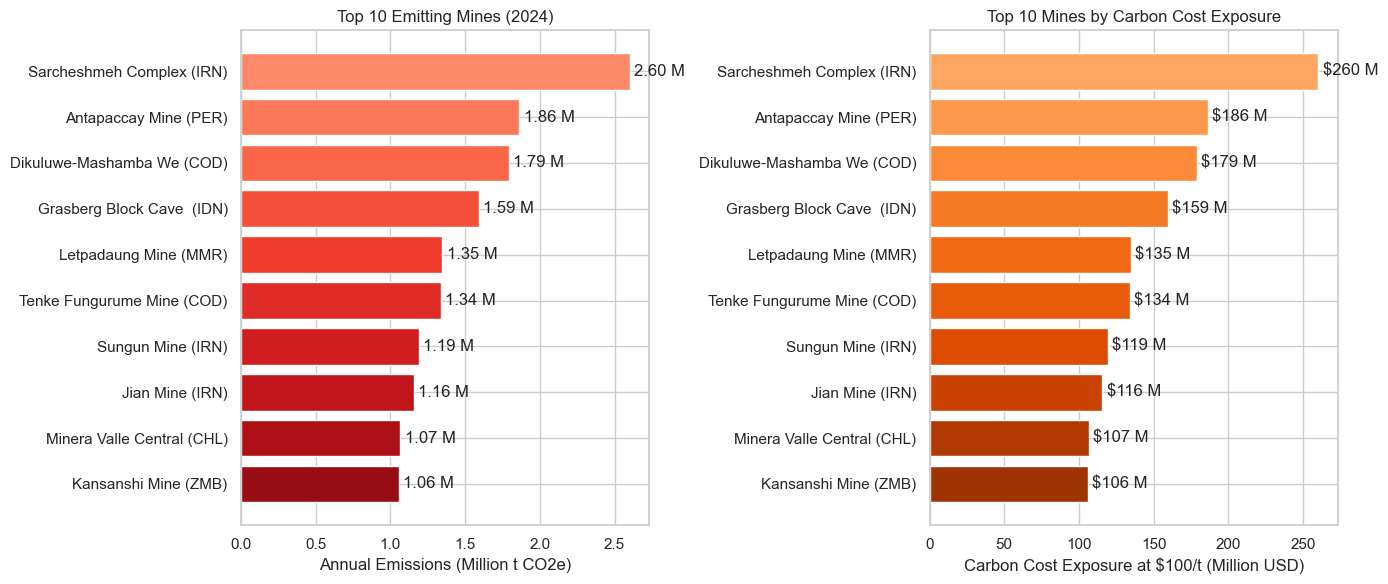

Saved: viz_top_emitters.png


In [74]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top 10 Emitters
ax1 = axes[0]
top_emitters = df_output.nlargest(10, 'annual_emissions_t_co2e')[['source_name', 'iso3_country', 'annual_emissions_t_co2e']]
top_emitters['label'] = top_emitters['source_name'].str[:20] + ' (' + top_emitters['iso3_country'] + ')'
colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_emitters)))
bars1 = ax1.barh(top_emitters['label'][::-1], top_emitters['annual_emissions_t_co2e'].values[::-1] / 1e6, color=colors[::-1])
ax1.set_xlabel('Annual Emissions (Million t CO2e)')
ax1.set_title('Top 10 Emitting Mines (2024)')
ax1.bar_label(bars1, fmt='%.2f M', padding=3)

# Top 10 by Carbon Cost Exposure at $100/t
ax2 = axes[1]
top_exposure = df_output.nlargest(10, 'carbon_cost_usd_100')[['source_name', 'iso3_country', 'carbon_cost_usd_100']]
top_exposure['label'] = top_exposure['source_name'].str[:20] + ' (' + top_exposure['iso3_country'] + ')'
colors2 = plt.cm.Oranges(np.linspace(0.4, 0.9, len(top_exposure)))
bars2 = ax2.barh(top_exposure['label'][::-1], top_exposure['carbon_cost_usd_100'].values[::-1] / 1e6, color=colors2[::-1])
ax2.set_xlabel('Carbon Cost Exposure at $100/t (Million USD)')
ax2.set_title('Top 10 Mines by Carbon Cost Exposure')
ax2.bar_label(bars2, fmt='$%.0f M', padding=3)

plt.tight_layout()
plt.savefig('viz_top_emitters.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: viz_top_emitters.png")

---
## 8. Known Limitations

This section documents data quality issues and gaps that users should be aware of when using `copper_mining_cleaned.csv`.

### 8.1 Missing Countries Problem

When validating our asset-level aggregates against Climate Trace's official country totals, we found that **some countries have emissions in the national aggregates but no corresponding mines in the asset-level data**.

| Country | ISO Code | Official Emissions (t CO2e) | Our Calculation | Gap |
|---------|----------|----------------------------|-----------------|-----|
| Mauritania | MRT | 1,158,440 | 0 | 100% |
| Tanzania | TZA | 179,204 | 7,963 | 96% |
| Morocco | MAR | 161,220 | 0 | 100% |
| Congo | COG | 46,489 | 0 | 100% |
| Georgia | GEO | 9,190 | 0 | 100% |

**Why this happens:**
- Climate Trace's country aggregates may include **artisanal/small-scale mining** captured via satellite but not catalogued at asset level
- Some mines may not yet be added to the asset-level database
- Different estimation methodologies between top-down (country) and bottom-up (asset) approaches

**Impact:** Our dataset covers approximately **97% of global copper mining emissions** (3.33% gap). The missing countries are relatively minor producers except Mauritania.

**Recommendation:** Note this limitation when presenting country-level analysis. These countries will be underrepresented.

---

### 8.2 Ownership Data Coverage Gap

| Metric | Count | Percentage |
|--------|-------|------------|
| Mines WITH ownership data | 530 | 58% |
| Mines WITHOUT ownership data | 384 | 42% |

**Why this happens:**
- Not all mines have been linked to parent companies in Climate Trace's ownership database
- Some mines are operated by private companies not covered by corporate registries
- Complex ownership structures may not be fully mapped

**Impact:** Company-level exposure analysis will only cover 58% of mines. The 42% without ownership can still be analyzed by country or operator.

**Recommendation:** 
- Use `source_operator` field as a fallback (operational control)
- Flag company-level totals as "partial coverage"
- Consider manual research for high-emitting mines missing ownership

---

### 8.3 Confidence Levels

The confidence in emission estimates varies significantly:

| Confidence Level | Emissions Data | Activity Data |
|-----------------|----------------|---------------|
| Very Low | 28% | 26% |
| Low | 11% | 17% |
| Medium | 52% | 36% |
| High | 9% | 21% |

**Note:** The 2024 data has better confidence than historical years (2021-2023 were ~85% "very low"). This is why we selected 2024 as the analysis year.

**Recommendation:** For high-stakes decisions, filter to `emissions_confidence = 'medium'` or higher.

---
## 9. Output Data Dictionary

Reference for all columns in `copper_mining_cleaned.csv`.

### Identifiers

| Column | Type | Description | Example |
|--------|------|-------------|---------|
| `source_id` | int | Unique mine identifier from Climate Trace | 45944343 |
| `source_name` | str | Mine name | "Escondida Mine" |
| `iso3_country` | str | ISO 3-letter country code | "CHL" |
| `lat` | float | Latitude coordinate | -24.2667 |
| `lon` | float | Longitude coordinate | -69.0667 |
| `year` | int | Analysis year | 2024 |

### Emissions & Production

| Column | Type | Description | Unit |
|--------|------|-------------|------|
| `annual_emissions_t_co2e` | float | Total annual CO2-equivalent emissions | tonnes CO2e (100yr GWP) |
| `annual_production_t_ore` | float | Total annual copper ore production | tonnes |
| `avg_capacity_t` | float | Average monthly capacity | tonnes |
| `capacity_factor` | float | Capacity utilization rate | 0-1 ratio |
| `carbon_intensity` | float | Emissions per unit production | t CO2e / t ore |

### Carbon Cost Exposure

| Column | Type | Description |
|--------|------|-------------|
| `carbon_cost_usd_50` | float | Annual carbon cost at $50/tonne CO2e |
| `carbon_cost_usd_100` | float | Annual carbon cost at $100/tonne CO2e |
| `carbon_cost_usd_150` | float | Annual carbon cost at $150/tonne CO2e |
| `carbon_cost_usd_200` | float | Annual carbon cost at $200/tonne CO2e |

### Mine Characteristics

| Column | Type | Description | Values |
|--------|------|-------------|--------|
| `mine_status` | str | Operational status | "Production", "Closed", "Suspended" |
| `mine_type` | str | Mining method | "Underground", "Open Pit", "Both" |
| `other_minerals` | str | Other minerals extracted | "Gold", "Silver", etc. |

### Ownership

| Column | Type | Description |
|--------|------|-------------|
| `parent_name` | str | Ultimate parent company name (may be null) |
| `parent_headquarter_country` | str | Parent company HQ country |
| `source_operator` | str | Mine operator (more complete than parent) |
| `ownership_complexity` | int | Number of ownership records (indicates complex structures) |
| `has_ownership` | bool | Whether parent company data exists |

### Data Quality Flags

| Column | Type | Description |
|--------|------|-------------|
| `emissions_confidence` | str | Confidence level for emissions estimate: "very low", "low", "medium", "high" |
| `activity_confidence` | str | Confidence level for production estimate |
| `include_in_intensity` | bool | Whether mine is eligible for intensity calculations (active status) |
| `activity_issue` | bool | True if production data has quality issues |
| `intensity_outlier` | bool | True if carbon intensity is >3 std from mean |
| `data_quality_flag` | str | Specific issue description (if any) |